# Data Cleaning (CSV, API, Web Scrapping)

In [1]:
import pandas as pd
import re
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

### Cleaning CSV

**Import Dataset (CSV)**


In [2]:
data=pd.read_csv('src/atp_picks.csv',encoding='latin-1') #Incluir encoding='latin-1'o UTF-8/16 para que pueda abrir el archivo
print(data.shape) # ver cuantas filas/columnas tiene el archivo
data.head()

(115988, 31)


,Unnamed: 0,TourRank,RID,Tour,GameD,Year,Name_1,Name_2,Result,GRes,...,K12,P2,P1,ClfML,ClfSC,P_2-0,P_0-2,P_2-1,P_1-2,REGR
0,0,2,1,European Open - Antwerp,10/13/2019,2019,Carlos Taberner,Antoine Hoang,2-6 6-3 2-6,0,...,0.238095,0.585277,0.414723,0,1,0.253032,0.380474,0.139216,0.227278,23.023090
1,1,2,1,European Open - Antwerp,10/13/2019,2019,Kamil Majchrzak,Sergiy Stakhovsky,6-3 6-3,1,...,NaN,0.534566,0.465434,0,0,0.337890,0.294525,0.180302,0.187284,23.066616
2,2,2,1,European Open - Antwerp,10/13/2019,2019,Marco Trungelliti,Jaume Antoni Munar Clar,4-6 3-6,0,...,NaN,0.604345,0.395655,0,1,0.276434,0.387373,0.146444,0.189750,23.204985
3,3,2,1,European Open - Antwerp,10/13/2019,2019,Norbert Gombos,Kyle Edmund,6-4 6-7 6-3,1,...,NaN,0.731359,0.268641,0,1,0.161738,0.493853,0.138907,0.205501,23.505814
4,4,2,1,European Open - Antwerp,10/13/2019,2019,Paolo Lorenzi,Arnaud Bovy,6-7 6-1 6-4,1,...,0.086957,0.178389,0.821611,1,0,0.516236,0.128632,0.268843,0.086289,22.672202


**Checkout columns:**

In [3]:
data.columns

Index(['Unnamed: 0', 'TourRank', 'RID', 'Tour', 'GameD', 'Year', 'Name_1',
       'Name_2', 'Result', 'GRes', 'PS', 'TTL', 'TPoints', 'K1', 'K2', 'F1',
       'F2', 'SETS', 'K20', 'K02', 'K21', 'K12', 'P2', 'P1', 'ClfML', 'ClfSC',
       'P_2-0', 'P_0-2', 'P_2-1', 'P_1-2', 'REGR'],
      dtype='object')

**Drop columns not useful for the analysis:**

In [4]:
data=data.drop(columns=["Unnamed: 0","GameD",'K1','K2', 'F1','K20', 'K02', 'K21', 'K12', 'P2', 'P1', 'ClfML', 'ClfSC',
       'P_2-0', 'P_0-2', 'P_2-1', 'P_1-2','REGR',"TPoints",'F2',"PS"])

In [5]:
data.columns


Index(['TourRank', 'RID', 'Tour', 'Year', 'Name_1', 'Name_2', 'Result', 'GRes',
       'TTL', 'SETS'],
      dtype='object')

**Check columns with null rows:**

In [6]:
data.isnull().sum()


TourRank    0
RID         0
Tour        0
Year        0
Name_1      0
Name_2      0
Result      0
GRes        0
TTL         0
SETS        0
dtype: int64

**Rename columns:**

In [7]:
data=data.rename(columns={"TourRank":"Ranking","Tour":"Tournament","Name_1":"Player_1","Name_2":"Player_2","SETS":"Total_sets","TTL":"Total_games","GRes":"Winner","RID":"Round"})

In [8]:
data["Tournament"].value_counts().head()


M15 Tabarka            1829
M15 Antalya            1823
M15 Cancun             1725
M15 Sharm El Sheikh    1070
M15 Monastir            855
Name: Tournament, dtype: int64

In [9]:
data["Year"].value_counts()

2018    45401
2019    40080
2017    30507
Name: Year, dtype: int64

**Groupby Grand Slam tournaments and delete the other ones:**

In [10]:
slams=["Australian Open - Melbourne","French Open - Paris","Wimbledon - London","U.S. Open - New York"]
data["Grand_Slams"]=np.where(data["Tournament"].isin(slams),2,1)
data["Grand_Slams"].value_counts()

1    113430
2      2558
Name: Grand_Slams, dtype: int64

**Drop Rounds < 4 (Challenges):**

In [11]:
data.drop(data[data['Grand_Slams']<2].index, inplace = True)
data.drop(data[data['Round']<4].index, inplace = True)

In [12]:
data['Tournament'] = data['Tournament'].replace("Australian Open - Melbourne","Australian Open")
data['Tournament'] = data['Tournament'].replace("French Open - Paris","Roland Garros")
data['Tournament'] = data['Tournament'].replace("Wimbledon - London","Wimbledon")
data['Tournament'] = data['Tournament'].replace("U.S. Open - New York","US Open")

In [13]:
data['Total_sets'].value_counts()

3    700
2    643
Name: Total_sets, dtype: int64

**Create "Winner" column for winner players:**

In [14]:
data['Winner'] = data['Winner'].replace(0, data['Player_2'])
data['Winner'] = data['Winner'].replace(1, data['Player_1'])
data['Winner'].value_counts().head()

Rafael Nadal      62
Roger Federer     45
Novak Djokovic    43
Dominic Thiem     30
Marin Cilic       30
Name: Winner, dtype: int64

**Create "Looser" column for looser players:**

In [15]:
data['Looser']=np.where(data["Winner"]==data["Player_1"],0,1)
data['Looser'].value_counts()

1    700
0    643
Name: Looser, dtype: int64

In [16]:
data['Looser'] = data['Looser'].replace(1, data['Player_1'])
data['Looser'] = data['Looser'].replace(0, data['Player_2'])
data['Looser'].value_counts().head()

Jan-Lennard Struff      11
Albert Ramos-Vinolas    11
Adrian Mannarino        11
Robin Haase             11
Damir Dzumhur           11
Name: Looser, dtype: int64

In [17]:
data.columns

Index(['Ranking', 'Round', 'Tournament', 'Year', 'Player_1', 'Player_2',
       'Result', 'Winner', 'Total_games', 'Total_sets', 'Grand_Slams',
       'Looser'],
      dtype='object')

**Change the order of columns:**

In [18]:
column_order=['Year','Tournament','Round','Player_1', 'Player_2','Result','Winner','Ranking', 
        'Total_games', 'Total_sets','Looser', 'Grand_Slams']
data=data[column_order]

In [19]:
data_analysis = data[['Year','Tournament','Round','Player_1', 'Player_2','Result','Winner','Ranking', 
        'Total_games', 'Total_sets','Looser', 'Grand_Slams']]

In [20]:
data_analysis.to_csv("src/atp_clean.csv")

**Look for winners of last Grand Slams (2017,2018,2019):**

In [42]:
filter=data[(data["Round"]==12)]
GS_winners=filter.groupby("Winner").agg({"Round":"count","Total_games":"mean","Total_sets":"mean"})
GS_winners

,Round,Total_games,Total_sets
Winner,,,
Novak Djokovic,3,29.333333,2.666667
Rafael Nadal,5,28.000000,2.600000
Roger Federer,3,27.333333,2.666667


In [ ]:
GS_winners.sort_values("Round",ascending=False).head(10)

AttributeError: 'Rectangle' object has no property 'subplots'

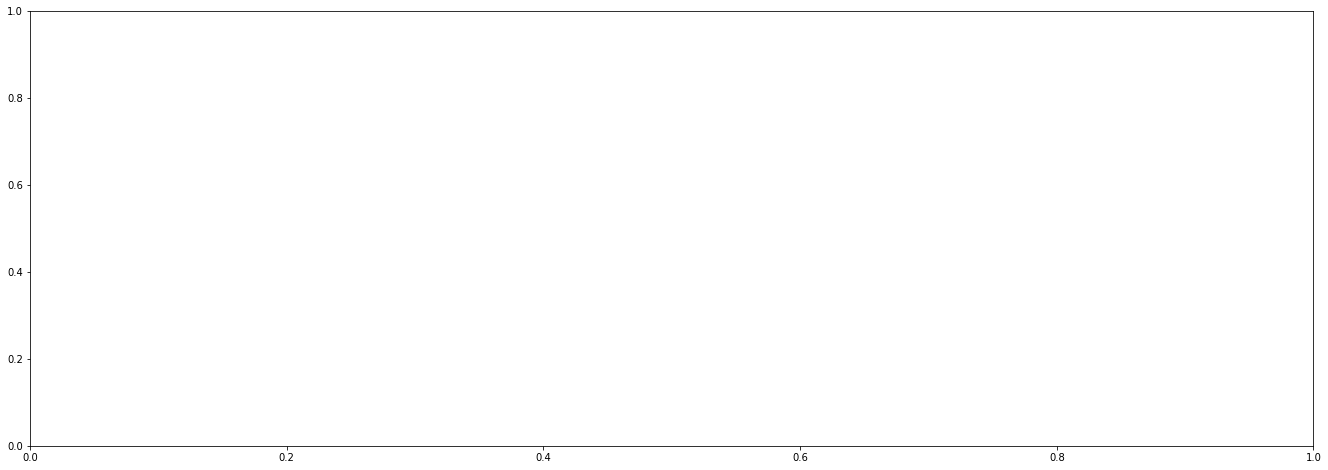

In [47]:
winner_filter=data[(data["Round"]==12)]
result2=winner_filter.groupby("Winner").agg({"Round":"count","Total_games":"mean","Total_sets":"mean"})
title2 = "Winners of Grand Slam Titles in the past three years"
fig, ax = plt.subplots(figsize=(23,8))
barplot = sns.barplot(subplots=True)
plt.title(title2+ "\n", fontsize=22)

### API

**API : Looking for personal details of winners of  last Grand Slams tournaments**

*As we can see from dataset, Roger Federer, Novak Djokovic and Rafael Nadal are the only three players winning all the Grand Slams Tournaments the last three years. So, we are looking for their personal details.*

In [27]:
# API look for player personal details
def getFromApi(path,queryParams=dict()):
    url=f"https://www.thesportsdb.com/api/v1/json/1{path}"
    res = requests.get(url,params=queryParams)
    print(res.status_code,res.url)
    return res.json()

In [28]:
#include params of each winner (Federer, Djokovic, Nadal)

params= {
    "id":"34161176"
}
Nadal = getFromApi("/lookupplayer.php",queryParams=params)

params= {
    "id":"34161173"
}
Federer = getFromApi("/lookupplayer.php",queryParams=params)

params= {
    "id":"34161179"
}
Djokovic = getFromApi("/lookupplayer.php",queryParams=params)


200 https://www.thesportsdb.com/api/v1/json/1/lookupplayer.php?id=34161176
200 https://www.thesportsdb.com/api/v1/json/1/lookupplayer.php?id=34161173
200 https://www.thesportsdb.com/api/v1/json/1/lookupplayer.php?id=34161179


In [29]:
def PlayersDetails(data):
    for player in data:
        return{
            "Name":player["strPlayer"],
            "Nacionality":player["strNationality"],
            "BirthDate":player["dateBorn"],
            "Height":player["strHeight"]
        }

Federer=PlayersDetails(Federer["players"])
Nadal=PlayersDetails(Nadal["players"])
Djokovic=PlayersDetails(Djokovic["players"])

In [30]:
Winner_details=[(Federer["Name"],Federer["Nacionality"],Federer["BirthDate"],Federer["Height"]),
                (Djokovic["Name"],Djokovic["Nacionality"],Djokovic["BirthDate"],Djokovic["Height"]),
                (Nadal["Name"],Nadal["Nacionality"],Nadal["BirthDate"],Nadal["Height"])]
           
Winner_details   

[('Roger Federer', 'Switzerland', '1981-08-08', '1.85'),
 ('Novak Djokovic', 'Serbia', '1987-05-22', '1.88'),
 ('Rafael Nadal', 'Spain', '1986-06-03', '1.85 m (6 ft 1 in)')]

In [31]:
data_winners=pd.DataFrame(Winner_details,columns=["Winner","Nacionality","BithDate","Height"])
data_winners

,Winner,Nacionality,BithDate,Height
0,Roger Federer,Switzerland,1981-08-08,1.85
1,Novak Djokovic,Serbia,1987-05-22,1.88
2,Rafael Nadal,Spain,1986-06-03,1.85 m (6 ft 1 in)


### WEB SCRAPPING

**Looking for total winner revenues:**

In [32]:
#Web Scrapping to look for player revenues 
url= "https://www.lanacion.com.ar/deportes/tenis/el-ranking-historico-ganancias-del-tenis-quien-nid2267639"
html=requests.get(url)
print(html)
soup=BeautifulSoup(html.text)
revenues=soup.select(".lista-desordenada")
print(revenues)

<Response [200]>
[<ul class="lista-desordenada">
<li>1. Novak Djokovic 134.684.000 dólares
</li>
<li>2. Roger Federer 126.266.005 dólares
</li>
<li>3. Rafael Nadal 110.279.818 dólares
</li>
<li>4. Andy Murray 61.199.017 dólares
</li>
<li>5. Pete Sampras 43.280.489 dólares 
</li>
<li>6. Stan Wawrinka 33.000.506 dólares
</li>
<li>7. David Ferrer 31.483.911 dólares
</li>
<li>8. Andre Agassi 31.152.975 dólares
</li>
<li>9. Tomas Berdych 29.426.828 dólares
</li>
<li>10. Marin Cilic 26.881.324 dólares
</li>
<li>11. Juan Martín del Potro 25.889.586 dólares
</li>
<li>12. Boris Becker 25.080.956 dólares
</li>
</ul>]


In [33]:
def PlayerRevenues(tag):
    td=tag.find_all("li")
    return{
        "Roger Federer":td[1].text.strip().replace("2. Roger Federer ",""),
        "Novak Djokovic":td[0].text.strip().replace("1. Novak Djokovic ",""),
        "Rafael Nadal":td[2].text.strip().replace("3. Rafael Nadal ","")
    }
Player_revenues=PlayerRevenues(revenues[0])
Player_revenues

{'Roger Federer': '126.266.005 dólares',
 'Novak Djokovic': '134.684.000 dólares',
 'Rafael Nadal': '110.279.818 dólares'}

In [34]:
data_revenues=pd.DataFrame([[key,Player_revenues[key]] for key in Player_revenues.keys()],columns=["Winner","Revenues"])
data_revenues.head()

,Winner,Revenues
0,Roger Federer,126.266.005 dólares
1,Novak Djokovic,134.684.000 dólares
2,Rafael Nadal,110.279.818 dólares


In [35]:
data_winners = pd.merge(data_winners, data_revenues, on='Winner')
data_winners

,Winner,Nacionality,BithDate,Height,Revenues
0,Roger Federer,Switzerland,1981-08-08,1.85,126.266.005 dólares
1,Novak Djokovic,Serbia,1987-05-22,1.88,134.684.000 dólares
2,Rafael Nadal,Spain,1986-06-03,1.85 m (6 ft 1 in),110.279.818 dólares


In [36]:
data_winners.to_csv("src/winners_clean.csv")